In [1]:
import pandas as pd

df_model = pd.read_csv(r"\Part 3 model building\Model_Data\df_model.csv")

In [3]:
#############################   XGBOOST



import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold


categorical_cols = ['Fuel','Transmission','Manufacturer' , 'Model']
numerical_cols = ['Age','Mileage','Horse Power',]

df_model[categorical_cols] = df_model[categorical_cols].astype('category')

X = pd.concat([df_model[numerical_cols], df_model[categorical_cols]], axis=1)
y = df_model['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)




def objective(params):

    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])

    model = xgb.XGBRegressor(enable_categorical=True, **params)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if len(X_val) == 0:
            continue

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r = model.score(X_val, y_val)
        rmse_scores.append(rmse)
        r_scores.append(r)

    if len(rmse_scores) == 0:
        return {'loss': np.inf, 'status': STATUS_OK}

    mean_rmse = np.mean(rmse_scores)
    mean_r = np.mean(r_scores)
    return {'loss': -mean_r, 'status': STATUS_OK}


space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),  # Number of boosting rounds (trees) to be built
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5), # Step size shrinkage used in update to prevent overfitting
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9, 12]), # Maximum depth of a tree, controls complexity of the tree model
    'min_child_weight': hp.choice('min_child_weight', [1, 3, 5, 7]), # Minimum sum of instance weight needed in a child
    'subsample': hp.uniform('subsample', 0.6, 1.0), # Subsample ratio of the training instances
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0), # Subsample ratio of columns when constructing each tree
    'gamma': hp.uniform('gamma', 0, 0.4),  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.05), # L1 regularization term on weights
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.05), # L2 regularization term on weights
    'objective': 'reg:squarederror',  # Use squared error for regression task
    'eval_metric': 'rmse',  # Root Mean Squared Error for evaluation
    'seed': 42  # Fix the seed for reproducibility
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  
            trials=trials)

best_params_xgb = space_eval(space, best)
print("Best hyperparameters:", best_params_xgb)

final_model_xgb = xgb.XGBRegressor(enable_categorical=True, **best_params_xgb)
final_model_xgb.fit(X_train, y_train)


kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
rmse_scores = []
mae_scores = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(enable_categorical=True,**best_params_xgb)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"Fold {i+1}:")
    print("Training R2:", r2_train)
    print("Testing R2:", r2_test)
    print("Testing RMSE:", rmse_test)
    print("Testing MAE:", mae_test)
    print("----------------------------------")

    r2_scores.append(r2_test)
    rmse_scores.append(rmse_test)
    mae_scores.append(mae_test)

mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

print("Mean R2:", mean_r2)
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)

100%|██████████| 100/100 [12:17<00:00,  7.38s/trial, best loss: -0.9110202510174998]
Best hyperparameters: {'colsample_bytree': 0.7641198341195425, 'eval_metric': 'rmse', 'gamma': 0.23029874339193984, 'learning_rate': 0.0344000097791391, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 400, 'objective': 'reg:squarederror', 'reg_alpha': 0.0007755632848663787, 'reg_lambda': 0.02776979265255367, 'seed': 42, 'subsample': 0.7971456676048367}
Fold 1:
Training R2: 0.9823289062832704
Testing R2: 0.9122728571486781
Testing RMSE: 13244.320835003567
Testing MAE: 6681.705696584132
----------------------------------
Fold 2:
Training R2: 0.9831745156555514
Testing R2: 0.9125696453399108
Testing RMSE: 15678.77978303816
Testing MAE: 7590.893477951064
----------------------------------
Fold 3:
Training R2: 0.9833953846650756
Testing R2: 0.9142558246547966
Testing RMSE: 12835.287590174335
Testing MAE: 6750.970541430367
----------------------------------
Fold 4:
Training R2: 0.9852818533376827
Test

<Axes: title={'center': 'XGBoost Feature Importance'}, xlabel='Feature Importance', ylabel='Features'>

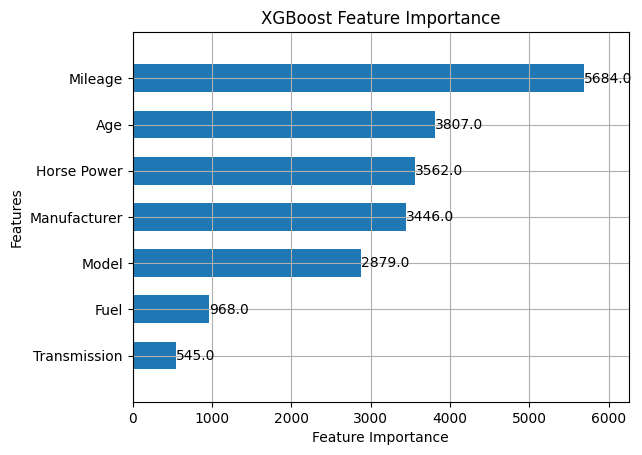

In [4]:
from xgboost import plot_importance


plot_importance(final_model_xgb, importance_type='weight', max_num_features=10, height=0.6,
                title='XGBoost Feature Importance', xlabel='Feature Importance', ylabel='Features', show_values=True)



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

categorical_cols = ['Fuel', 'Transmission', 'Manufacturer', 'Model']
numerical_cols = ['Age', 'Mileage', 'Horse Power']

df_categorical = pd.get_dummies(df_model[categorical_cols], drop_first=True)

X = pd.concat([df_model[numerical_cols], df_categorical], axis=1)
y = df_model['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])





mlp_regressor = MLPRegressor(hidden_layer_sizes=(6000, 3000, 2000, 1000, 500,250 ),
                             activation='relu',
                             solver='adam',
                             alpha=0.0001,
                             batch_size='auto',
                             learning_rate='constant',
                             max_iter=1000,
                             random_state=42)

mlp_regressor.fit(X_train, y_train)


y_pred = mlp_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Absolute Error (MAE): 8712.119124759007
Root Mean Squared Error (RMSE): 16347.14653619937
R-squared (R2) Score: 0.8663532164463116


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

categorical_cols = ['Fuel','Transmission','Manufacturer' , 'Model']
numerical_cols = ['Age','Mileage','Horse Power',]

df_model[categorical_cols] = df_model[categorical_cols].astype('category')

X = pd.concat([df_model[numerical_cols], df_model[categorical_cols]], axis=1)
y = df_model['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

def objective(params):
    model = lgb.LGBMRegressor(**params, verbosity = -1)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r = model.score(X_val, y_val)
        r_scores.append(r)

    mean_r = np.mean(r_scores)
    return {'loss': -mean_r, 'status': STATUS_OK}

space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9, 12]),
    'num_leaves': hp.choice('num_leaves', [20, 30, 40, 50, 60]),
    'min_child_samples': hp.choice('min_child_samples', [10, 20, 30, 40, 50]),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.05),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.05),
    'objective': 'regression',  # Use regression for the objective function
    'metric': 'rmse',  # Root Mean Squared Error for evaluation
    'seed': 42  # Fix the seed for reproducibility
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

best_params_lgb = space_eval(space, best)
print("Best hyperparameters:", best_params_lgb)

final_model_lgb = lgb.LGBMRegressor(**best_params_lgb)
final_model_lgb.fit(X_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
rmse_scores = []
mae_scores = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = lgb.LGBMRegressor(**best_params_lgb, verbosity = -1)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"Fold {i+1}:")
    print("Training R2:", r2_train)
    print("Testing R2:", r2_test)
    print("Testing RMSE:", rmse_test)
    print("Testing MAE:", mae_test)
    print("----------------------------------")

    r2_scores.append(r2_test)
    rmse_scores.append(rmse_test)
    mae_scores.append(mae_test)

mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

print("Mean R2:", mean_r2)
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)


100%|██████████| 100/100 [02:04<00:00,  1.25s/trial, best loss: -0.9038241029947891]
Best hyperparameters: {'colsample_bytree': 0.7218450216924488, 'learning_rate': 0.052354646691557184, 'max_depth': 12, 'metric': 'rmse', 'min_child_samples': 10, 'n_estimators': 500, 'num_leaves': 20, 'objective': 'regression', 'reg_alpha': 0.02020665668255966, 'reg_lambda': 0.03939202515861011, 'seed': 42, 'subsample': 0.8241487325518865}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 4276, number of used features: 7
[LightGBM] [Info] Start training from score 50593.387044
Fold 1:
Training R2: 0.9720053740606696
Testing R2: 0.9080007776087321
Testing RMSE: 13562.969288946377
Testing MAE: 7221.013906548517
---------------

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

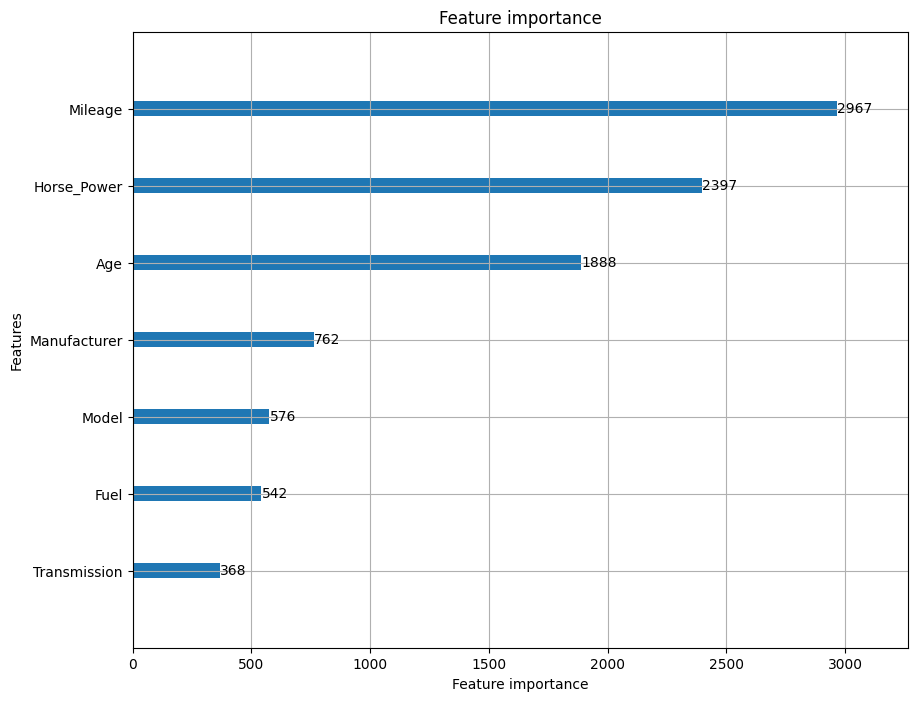

In [7]:
lgb.plot_importance(final_model_lgb, max_num_features=len(X.columns), figsize=(10, 8))

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor, Pool
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

categorical_cols = ['Fuel','Transmission','Manufacturer' , 'Model']
numerical_cols = ['Age','Mileage','Horse Power']

df_model[categorical_cols] = df_model[categorical_cols].astype('category')

X = df_model[numerical_cols + categorical_cols]
y = df_model['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(params):
    model = CatBoostRegressor(**params, silent=True)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
        val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_cols)

        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    return {'loss': -mean_r2, 'status': STATUS_OK}

space = {
    'iterations': hp.choice('iterations', [100, 200, 300, 400, 500]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'depth': hp.choice('depth', [3, 5, 7, 9, 12]),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 5),
    'random_strength': hp.uniform('random_strength', 0, 100),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'grow_policy': hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
    'eval_metric': 'RMSE',
    'random_seed': 42
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

best_params_cat = space_eval(space, best)
print("Best hyperparameters:", best_params_cat)

final_model_cat = CatBoostRegressor(**best_params_cat, silent=True)
final_model_cat.fit(X_train, y_train, cat_features=categorical_cols, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
rmse_scores = []
mae_scores = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor(**best_params_cat, silent=True)
    model.fit(X_train, y_train, cat_features=categorical_cols, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"Fold {i+1}:")
    print("Training R2:", r2_train)
    print("Testing R2:", r2_test)
    print("Testing RMSE:", rmse_test)
    print("Testing MAE:", mae_test)
    print("----------------------------------")

    r2_scores.append(r2_test)
    rmse_scores.append(rmse_test)
    mae_scores.append(mae_test)

mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

print("Mean R2:", mean_r2)
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)

100%|██████████| 100/100 [1:56:17<00:00, 69.77s/trial, best loss: -0.8925188416893279] 
Best hyperparameters: {'bagging_temperature': 0.22797765761515862, 'border_count': 256, 'depth': 7, 'eval_metric': 'RMSE', 'grow_policy': 'SymmetricTree', 'iterations': 500, 'l2_leaf_reg': 0.8840617129113807, 'learning_rate': 0.14340770994107624, 'random_seed': 42, 'random_strength': 61.22298184861944}
Fold 1:
Training R2: 0.94624616800449
Testing R2: 0.8883688666084093
Testing RMSE: 14940.164081203295
Testing MAE: 7761.2398434553725
----------------------------------
Fold 2:
Training R2: 0.9481252379413696
Testing R2: 0.8944360134223969
Testing RMSE: 17228.16536122897
Testing MAE: 8677.573839572731
----------------------------------
Fold 3:
Training R2: 0.9462895812845963
Testing R2: 0.8998649662779173
Testing RMSE: 13870.634064251606
Testing MAE: 7372.795247196143
----------------------------------
Fold 4:
Training R2: 0.9531063112781908
Testing R2: 0.8925508585248352
Testing RMSE: 15633.111904331

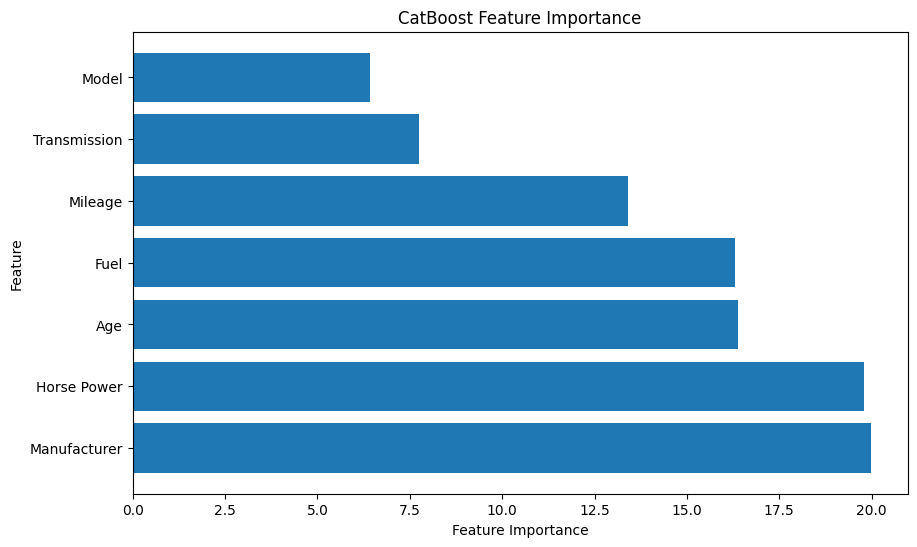

In [9]:
import matplotlib.pyplot as plt

feature_importance = final_model_cat.get_feature_importance()

feature_names = X.columns

feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_feature_names = [x[0] for x in sorted_feature_importance]
sorted_feature_scores = [x[1] for x in sorted_feature_importance]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_scores)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.show()


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


categorical_cols = ['Fuel', 'Transmission', 'Manufacturer', 'Model']
numerical_cols = ['Age', 'Mileage', 'Horse Power']

X = df_model[numerical_cols + categorical_cols]
y = df_model['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
for col in categorical_cols:
    X_train_cat[col] = X_train_cat[col].astype('category')
    X_test_cat[col] = X_test_cat[col].astype('category')



categorical_cols_mlp = ['Fuel', 'Transmission', 'Manufacturer', 'Model']
numerical_cols_mlp = ['Age', 'Mileage', 'Horse Power']

df_categorical_mlp = pd.get_dummies(df_model[categorical_cols], drop_first=True)

X_mlp = pd.concat([df_model[numerical_cols], df_categorical], axis=1)
y = df_model['Price']

X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_mlp[numerical_cols] = scaler.fit_transform(X_train_mlp[numerical_cols])
X_test_mlp[numerical_cols] = scaler.transform(X_test_mlp[numerical_cols])



xgb_pred = final_model_xgb.predict(X_test_cat)
lgb_pred = final_model_lgb.predict(X_test_cat)
catboost_pred = final_model_cat.predict(X_test_cat)
mlp_pred = mlp_regressor.predict(X_test_mlp)

X_meta = np.column_stack((xgb_pred, lgb_pred, catboost_pred, mlp_pred))

k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True, random_state=52)

train_r2_list = []
test_r2_list = []
test_rmse_list = []
test_mae_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X_meta), 1):
    X_train_cv, X_test_cv = X_meta[train_index], X_meta[test_index]
    y_train_cv, y_test_cv = y_test.iloc[train_index], y_test.iloc[test_index]
    
    meta_model_cv = LinearRegression()
    meta_model_cv.fit(X_train_cv, y_train_cv)
    
    train_pred_cv = meta_model_cv.predict(X_train_cv)
    test_pred_cv = meta_model_cv.predict(X_test_cv)
    
    train_r2_cv = r2_score(y_train_cv, train_pred_cv)
    test_r2_cv = r2_score(y_test_cv, test_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_test_cv, test_pred_cv))
    mae_cv = mean_absolute_error(y_test_cv, test_pred_cv)
    
    train_r2_list.append(train_r2_cv)
    test_r2_list.append(test_r2_cv)
    test_rmse_list.append(rmse_cv)
    test_mae_list.append(mae_cv)
    
    print(f"Fold {fold}:")
    print("Train R^2:", train_r2_cv)
    print("Test R^2:", test_r2_cv)
    print("Test RMSE:", rmse_cv)
    print("Test MAE:", mae_cv)
    print()
    

mean_test_r2 = np.mean(test_r2_list)
mean_test_rmse = np.mean(test_rmse_list)
mean_test_mae = np.mean(test_mae_list)

print("Mean Test R^2:", mean_test_r2)
print("Mean Test RMSE:", mean_test_rmse)
print("Mean Test MAE:", mean_test_mae)


Fold 1:
Train R^2: 0.9138125777477875
Test R^2: 0.9376344441661644
Test RMSE: 10836.281606687213
Test MAE: 5948.379079074085

Fold 2:
Train R^2: 0.9111714479819273
Test R^2: 0.9435550214941419
Test RMSE: 11067.505054855512
Test MAE: 6578.134980369514

Fold 3:
Train R^2: 0.9136606951996014
Test R^2: 0.9369147545490205
Test RMSE: 10933.918298913382
Test MAE: 6412.005362703149

Fold 4:
Train R^2: 0.9404608950721006
Test R^2: 0.8574719082293887
Test RMSE: 19518.509034903997
Test MAE: 8494.593106532235

Fold 5:
Train R^2: 0.9164895890902881
Test R^2: 0.9302195910023008
Test RMSE: 9754.105095612582
Test MAE: 5644.889733503577

Mean Test R^2: 0.9211591438882032
Mean Test RMSE: 12422.063818194538
Mean Test MAE: 6615.600452436513


In [11]:
meta_model = LinearRegression()
meta_model.fit(X_meta, y_test)

LinearRegression()

In [ ]:
import joblib

joblib.dump(final_model_xgb, r"\Part 3 model building\models\xgb_model.pkl")

joblib.dump(final_model_lgb, r"\Part 3 model building\Models\lgb_model.pkl")

final_model_cat.save_model(r"\Part 3 model building\Models\catboost_model.cbm")

joblib.dump(mlp_regressor, r"\Part 3 model building\Models\mlp_model.pkl")

joblib.dump(meta_model, r"\Part 3 model building\Models\meta_model.pkl")
